In [180]:
# #%pip install pyodbc
# %pip install numpy
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib.pyplot
# %pip install pyodbc

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
from datetime import date

#get today's date
today = date.today()
#format today's date
date_today = today.strftime("%b %d, %Y")

In [182]:
#Bring in necessary credentials
from configparser import ConfigParser

parser = ConfigParser()
_ = parser.read('notebook.cfg')

driver = parser.get('sql_server', 'driver')
server = parser.get('sql_server', 'server')
db = parser.get('sql_server', 'db')
mail_to = parser.get('gmail_credentials', 'mail_to')
mail_from = parser.get('gmail_credentials', 'mail_from')
pw = parser.get('gmail_credentials', 'pw')

In [183]:
conn = pyodbc.connect(f'{driver}'
                      f'{server}'
                      f'{db}'
                      'Trusted_Connection=yes;')

In [184]:
# sql script to generate data
sql = """select concat(a.FirstName,' ',a.LastName) as CustomerName, 
		b.OrderDate, 
		year(b.OrderDate) as year,
		month(b.OrderDate) as month,
		b.SalesAmount, 
		c.CurrencyAlternateKey,
		d.EnglishProductName as Product,
		e.EnglishProductSubcategoryName as SubCategory,
		f.EnglishProductCategoryName as Category
from [dbo].[DimCustomer] a, 
		[dbo].[FactInternetSales] b, 
		[dbo].[DimCurrency] c,
		[dbo].[DimProduct] d,
		[dbo].[DimProductSubcategory] e,
		[dbo].[DimProductCategory] f
where a.CustomerKey = b.CustomerKey
and b.CurrencyKey = c.CurrencyKey
and b.ProductKey = d.ProductKey
and d.ProductSubcategoryKey = e.ProductSubcategoryKey
and e.ProductCategoryKey = f.ProductCategoryKey 
and b.OrderDate <= '2013-12-31'"""

In [185]:
# query bd using sql script 
df = pd.read_sql(sql, conn)
print(df.head())

# Close Connection to db
conn.close()

C:\Users\lizat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


       CustomerName  OrderDate  year  month  SalesAmount CurrencyAlternateKey  \
0       Cole Watson 2010-12-29  2010     12    3578.2700                  CAD   
1  Rachael Martinez 2010-12-29  2010     12    3399.9900                  FRF   
2     Sydney Wright 2010-12-29  2010     12    3399.9900                  USD   
3      Ruben Prasad 2010-12-29  2010     12     699.0982                  USD   
4       Christy Zhu 2010-12-29  2010     12    3399.9900                  AUD   

                   Product     SubCategory Category  
0         Road-150 Red, 62      Road Bikes    Bikes  
1  Mountain-100 Silver, 44  Mountain Bikes    Bikes  
2  Mountain-100 Silver, 44  Mountain Bikes    Bikes  
3       Road-650 Black, 62      Road Bikes    Bikes  
4  Mountain-100 Silver, 44  Mountain Bikes    Bikes  


In [186]:
total_sales = round(df['SalesAmount'].sum(),2)
total_sales

29312982.5

In [187]:
ytd_df = df[df['year'] == df['year'].max()]
ytd_df.head()

,CustomerName,OrderDate,year,month,SalesAmount,CurrencyAlternateKey,Product,SubCategory,Category
5627,Cindy Patel,2013-01-01,2013,1,2294.99,USD,"Mountain-200 Black, 42",Mountain Bikes,Bikes
5628,Cindy Patel,2013-01-01,2013,1,4.99,USD,Water Bottle - 30 oz.,Bottles and Cages,Accessories
5629,Cindy Patel,2013-01-01,2013,1,9.99,USD,Mountain Bottle Cage,Bottles and Cages,Accessories
5630,Brad She,2013-01-01,2013,1,2443.35,USD,"Road-250 Black, 52",Road Bikes,Bikes
5631,Nicole Brown,2013-01-01,2013,1,2319.99,GBP,"Mountain-200 Silver, 38",Mountain Bikes,Bikes


In [188]:
ytd_s = round(ytd_df['SalesAmount'].sum(),2)
ys = [ytd_s]
ytd_sales = pd.DataFrame(ys, columns=['ytd_sales']) 
ytd_sales

,ytd_sales
0,16351550.34


In [189]:
txn_m = len(pd.unique(ytd_df['CustomerName']))
tm = [txn_m]
txn_merch = pd.DataFrame(tm, columns=['txn_merch']) 
txn_merch

,txn_merch
0,17354


In [190]:
ytd_category = ytd_df.groupby("Category").sum()[["SalesAmount"]]
ytd_category

,SalesAmount
Category,
Accessories,668241.53
Bikes,15359502.36
Clothing,323806.45


In [191]:
ytd_curr = ytd_df.groupby("CurrencyAlternateKey").sum()[["SalesAmount"]]
ytd_curr

,SalesAmount
CurrencyAlternateKey,
AUD,4338938.60
CAD,1085563.26
GBP,2124358.41
USD,8802690.07


In [192]:
yr_trend = df.groupby("year").sum()[["SalesAmount"]]
yr_trend["SalesAmount"] = round(yr_trend["SalesAmount"] / 1000000, 2)
yr_trend

,SalesAmount
year,
2010,0.04
2011,7.08
2012,5.84
2013,16.35


In [193]:
mth_trend = ytd_df.groupby("month").sum()[["SalesAmount"]]
mth_trend["SalesAmount"] = round(mth_trend["SalesAmount"] / 1000000, 2)
mth_trend

,SalesAmount
month,
1,0.86
2,0.77
3,1.05
4,1.05
5,1.28
6,1.64
7,1.37
8,1.55
9,1.45


In [194]:
%matplotlib inline

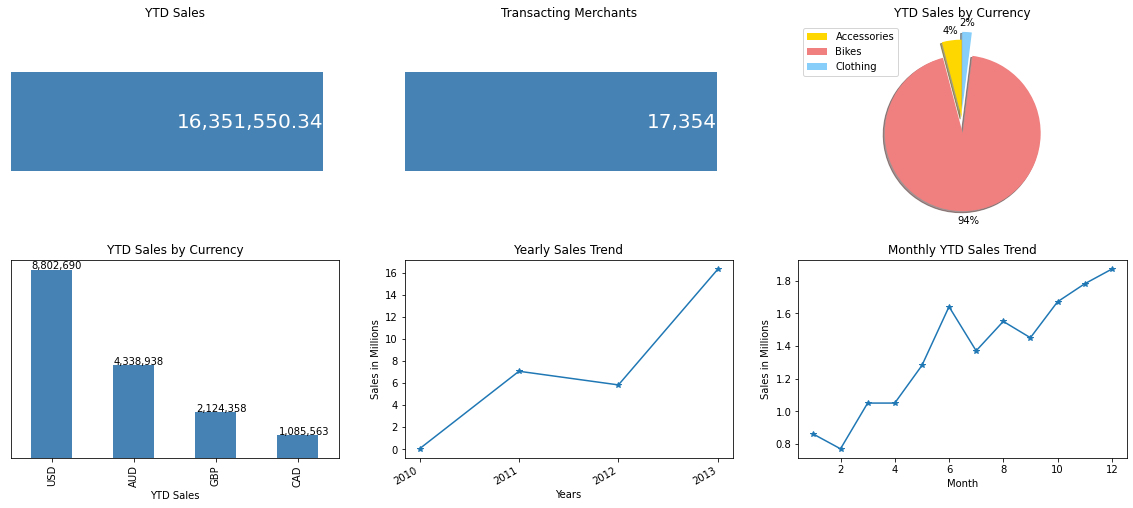

In [195]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 3, 1) # add subplot 1 (2 rows, 3 columns, first plot)
ax1 = fig.add_subplot(2, 3, 2) # add subplot 2 (2 rows, 3 columns, second plot)
ax2 = fig.add_subplot(2, 3, 3) # add subplot 2 (2 rows, 3 columns, third plot)
ax3 = fig.add_subplot(2, 3, 4) # add subplot 2 (2 rows, 3 columns, fourth plot)
ax4 = fig.add_subplot(2, 3, 5) # add subplot 2 (2 rows, 3 columns, fifth plot)
ax5 = fig.add_subplot(2, 3, 6) # add subplot 2 (2 rows, 3 columns, sixth plot)

       
# Subplot 1: Barh plot
ytd_sales.plot(kind='barh', color='steelblue', edgecolor = "none", figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('YTD Sales')
ax0.axes.xaxis.set_visible(False)
ax0.axes.yaxis.set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.get_legend().remove()

for index, value in enumerate(ytd_sales.index):
    label = ytd_sales['ytd_sales'][value]

ax0.annotate("{:,}".format(label), xy=(label, index),  color='white',ha='right', va='center', size = 20)

# Subplot 2: Barh plot
txn_merch.plot(kind='barh', color='steelblue', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title('Transacting Merchants')
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_legend().remove()

for index, value in enumerate(txn_merch.index):
    label = txn_merch['txn_merch'][value]

ax1.annotate("{:,}".format(label), xy=(label, index),  color='white',ha='right', va='center', size = 20)

# Subplot 3: Pie Chart
colors_list = ['gold', 'lightcoral', 'lightskyblue']
explode_list = [0, 0.2, 0.1] # ratio for each pie with which to offset each wedge.
ytd_category['SalesAmount'].plot(kind='pie',
                            figsize=(20, 6),
                            autopct='%1.0f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list,
                            ax=ax2 # 'explode' lowest 3 continents
                            ) # add to subplot 3
ax2.set_title('YTD Sales by Currency')
ax2.axis('equal') 
ax2.legend(labels=ytd_category.index, loc='upper left') 
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

# Subplot 4: Barh plot
ytd_curr.sort_values('SalesAmount', ascending=False).plot(kind='bar', color='steelblue', figsize=(20, 8), ax=ax3) # add to subplot 4
ax3.set_title('YTD Sales by Currency')
ax3.set_ylabel('Currency')
ax3.set_xlabel('YTD Sales')
for p in ax3.patches:
    ax3.annotate("{:,}".format(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), ha='left' )
ax3.axes.yaxis.set_visible(False)
ax3.get_legend().remove()

# Subplot 5: Line plot
yr_trend.plot(kind='line', marker = "*", figsize=(20, 8), ax=ax4) # add to subplot 5
ax4.set_title ('Yearly Sales Trend')
ax4.set_ylabel('Sales in Millions')
ax4.set_xlabel('Years')
ax4.get_legend().remove()
ax4.locator_params(axis="x", nbins=4)
ax4.ticklabel_format(axis="y", style="plain")
plt.setp(ax4.get_xticklabels(), rotation=30, ha='right')

# Subplot 6: Line plot
mth_trend.plot(kind='line', marker = "*", figsize=(20, 8), ax=ax5) # add to subplot 6
ax5.set_title ('Monthly YTD Sales Trend')
ax5.set_ylabel('Sales in Millions')
ax5.set_xlabel('Month')
ax5.get_legend().remove()

#save dashboard as png image file
plt.savefig("Dashboard.png",
            pad_inches = 1,
            facecolor ="w",
            orientation ='landscape')
            
plt.show()

In [196]:
# Import modules
import smtplib, ssl
## email.mime subclasses
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
### Add new subclass for adding attachments
from email.mime.application import MIMEApplication

# Define the HTML document
html = '''
    <html>
    <head></head>
    <body>
    <p><h3>Dashboard</h3></p>
    <img src="cid:myimageid" width="80%">
    </body>
    </html>
    '''
# Define a function to attach files as MIMEApplication to the email
    ## Add another input extra_headers default to None
##############################################################
def attach_file_to_email(email_message, filename, extra_headers=None):
    # Open the attachment file for reading in binary mode, and make it a MIMEApplication class
    with open(filename, "rb") as f:
        file_attachment = MIMEApplication(f.read())
    # Add header/name to the attachments    
    file_attachment.add_header(
        "Content-Disposition",
        f"attachment; filename= {filename}",
    )
    # Set up the input extra_headers for img
      ## Default is None: since for regular file attachments, it's not needed
      ## When given a value: the following code will run
         ### Used to set the cid for image
    if extra_headers is not None:
        for name, value in extra_headers.items():
            file_attachment.add_header(name, value)
    # Attach the file to the message
    email_message.attach(file_attachment)
############################################################## 

# Create a MIMEMultipart class, and set up the From, To, Subject fields
email_message = MIMEMultipart()
email_message['From'] = mail_from
email_message['To'] = mail_to
email_message['Subject'] = f'Python Dashboard as at {date_today}'

# Attach the html doc defined earlier, as a MIMEText html content type to the MIME message
email_message.attach(MIMEText(html, "html"))

# Attach more (documents)
  ## Apply function with extra_header on dashboard.png. This will render dashboard.png in the html content
##############################################################
attach_file_to_email(email_message, 'Dashboard.png', {'Content-ID': '<myimageid>'})
#this will attach the document
attach_file_to_email(email_message, 'Dashboard.png')


# Convert it as a string
email_string = email_message.as_string()

# Connect to the Gmail SMTP server and Send Email
context = ssl.create_default_context()
with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
    server.login(mail_from, pw)
    server.sendmail(mail_from, mail_to, email_string)
